In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib

In [2]:
df = pd.read_csv('/content/pca_transformed_data_25.csv')

In [3]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [4]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 50000
Training set size: 35000
Validation set size: 7500
Testing set size: 7500


In [5]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

In [6]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
X_train = df_train.drop('Test Results', axis=1)
y_train = df_train['Test Results']
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [7]:
# Print best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Best cross-validation accuracy for XGBoost: 0.8412571428571429


In [8]:
# Make predictions on test set
X_test = df_test.drop('Test Results', axis=1)
y_test = df_test['Test Results']
y_pred_xgb = grid_search_xgb.predict(X_test)

In [9]:
# Get classification report
report = classification_report(y_test, y_pred_xgb, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']  # Sensitivity
f1 = report['weighted avg']['f1-score']
accuracy = accuracy_score(y_test, y_pred_xgb)

Performance Metrics for XGBoost on Test Set:
        Metric     Value
0    Precision  0.842557
1  Sensitivity  0.842533
2     F1 Score  0.842442
3     Accuracy  0.842533


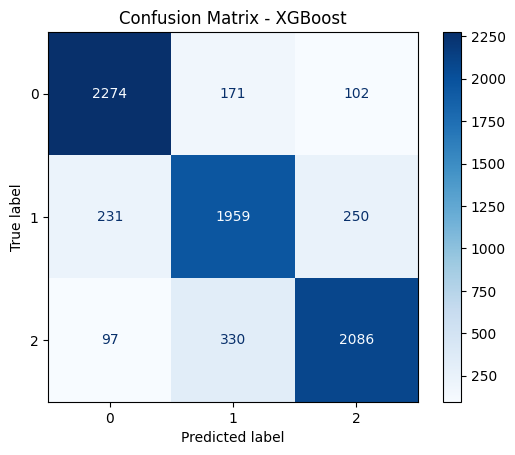

In [10]:
# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Sensitivity', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1, accuracy]
})

print("Performance Metrics for XGBoost on Test Set:")
print(metrics_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [11]:
best_model = grid_search_xgb.best_estimator_
joblib.dump(best_model, 'best_xgb_model.pkl')

print("Best model saved as best_xgb_model.pkl")

Best model saved as best_xgb_model.pkl


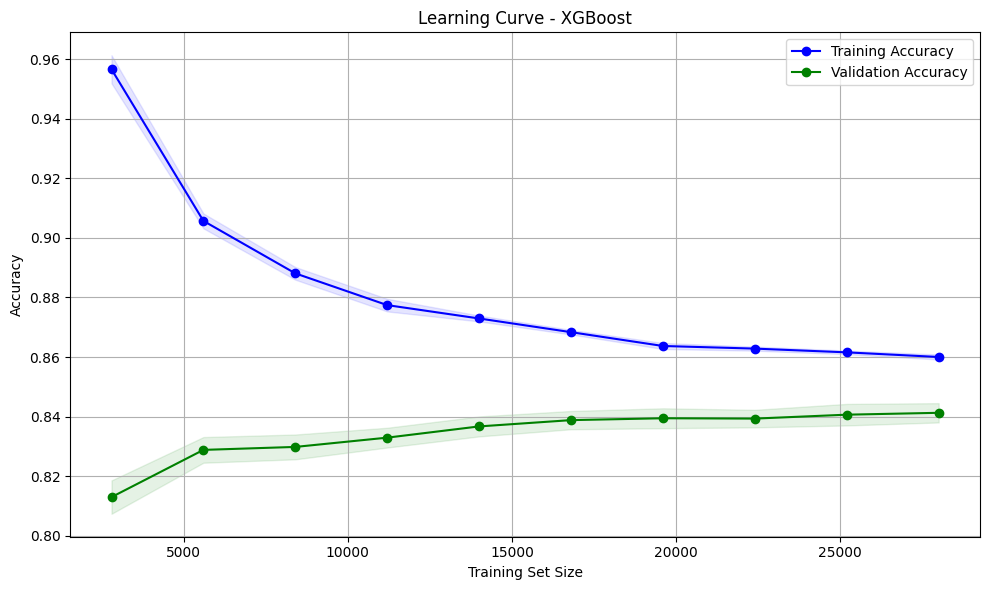

In [12]:
from sklearn.model_selection import learning_curve

# Use full training data for the learning curve
X_full_train = df_train.drop('Test Results', axis=1)
y_full_train = df_train['Test Results']

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_full_train,
    y=y_full_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title('Learning Curve - XGBoost')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
